<a href="https://colab.research.google.com/github/Patricia7sp/Desafios-DataScience/blob/main/CASE_IFOOD_AQUISI%C3%87AO_DE_UM_PRODUTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aquisição de um novo Produto gadget
*    O  Case será feito usando a biblioteca do pycaret

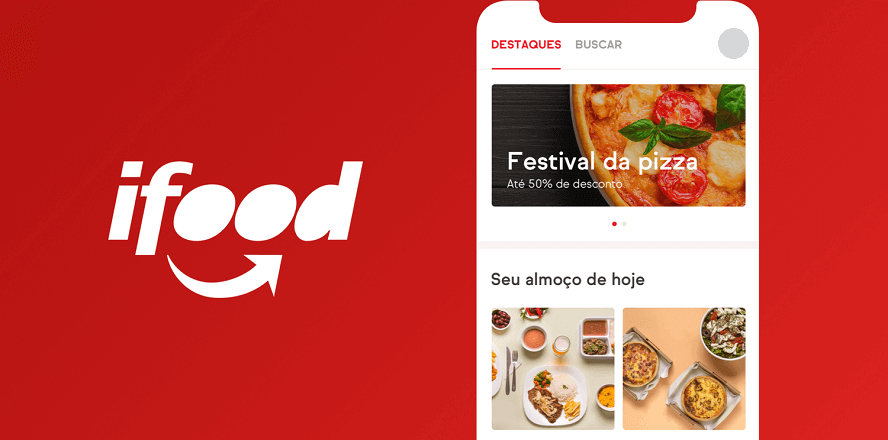

### 1.0 Instalanddo a biblioteca do pycaret

In [ ]:
!pip install pycaret

 ### 1.1  Importando as bibliotecas 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import scipy.stats as st
from scipy import stats
from statsmodels.formula.api  import ols

import seaborn as sns
from pycaret.utils import enable_colab
enable_colab()


 #### 1.3 Fazendo a leitura do dataset

In [ ]:
df = pd.read_csv('data.csv', sep=',')
df.head()

 #### Fazendo uma divisão dos dados para treino e teste

In [ ]:
df_train =df.iloc[:2000]

In [ ]:
# para testarmos novos dados ainda não visto
df_test= df.iloc[2000:240]

 ### 2.0 EDA

##### Verificando a quantidade de features 

In [ ]:
df.shape


Entendo como está estruturado os dados em termos outliers, valores nulos, média, desvio padrão

In [ ]:
def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result

def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique())>2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5*iqr_range
            upper = q3 + 1.5*iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc

def EDA_morestats(df):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    

 
    colunas = df.columns.tolist()
    
        
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), colunas), index=colunas)
    
    eda_df['Mean'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

In [ ]:
EDA_morestats(df_train)

##### Análise:
*   Valores como NaN - Das 29 features só temos 1 feature com 0.01% de valores faltantes, um valor insignificante para mim. Eu vou testar a performance do meu modelo eliminando esses valores da minha base  e tentarei também com o tratamento desses valores nulos, verificando se trás algum impacto para o meu modelo.

* Valores com Outliers - Temos algumas features com alguns valores discrepantes como; <br>
  Ano de nascimento, income, - é comum em uma pesquisa que não foi definida critérios, você ter uma ou outra  informação que estará fora da média . <br>
  

* Quero entender aqui como está a distribuição dos clientes que responderam ou não a oferta

In [ ]:
df_train.Response.value_counts()

In [ ]:
aceita = print(round(334/2240*100,2), '%')

In [ ]:
naoaceita= print(round(1906/2240*100,2), '%')

##### Análise  das respostas:
  * Tivemos como resposta à oferta, podemos assim dizer, somente  14,91% dos intrevistados. A variável target está com uma concrestação maior de resposta para quem não quis a oferta, ou seja, o modelo tende a ir muito mais pare este lado, que os clientes não irão aceitar a oferta. Para conseguirmos que o modelo dê o seu melhor em maximizar o máximo possível de lucro terei que nivelar os dados, igualar a quantidade de respostas como 0 e 1.


#### Plotando um histragama para verificar a distribuição das features



In [ ]:
def histograma(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 100]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 100, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 100)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 2.0, w_pad = 2.0, h_pad = 2.0)
    plt.show()

In [ ]:
histograma(df_train, 20,3)

In [ ]:
# Criancas em casa
df_train.Kidhome.value_counts()

In [ ]:
criancas = print(round(947/2240*100, 2),'%')

In [ ]:
# Verificando se esses pais responderam a oferta
df_train[['ID', 'Kidhome', 'Response']].groupby(['Kidhome', 'Response']).count()

In [ ]:
# percentual dos pais que responderam
umfilho = print(round(110/899*100, 2),'%')

In [ ]:
# percentual dos pais que responderam
doisfilhos = print(round(2/48*100, 2),'%')

In [ ]:
# que não são pais e responderam
semfilhos = print(round(222/1293*100, 2),'%')

In [ ]:
#  a camapanha 'AcceptedCmp3'
df_train[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds','AcceptedCmp3']].groupby([ 'AcceptedCmp3']).count()

In [ ]:
#a camapanha AcceptedCmp4
df_train[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','AcceptedCmp4']].groupby([ 'AcceptedCmp4']).count()

In [ ]:
# a camapanha AcceptedCmp3
df_train[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds','AcceptedCmp5']].groupby([ 'AcceptedCmp5']).count()

In [ ]:
#a camapanha AcceptedCmp2
df_train[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds','AcceptedCmp2']].groupby([ 'AcceptedCmp2']).count()

In [ ]:
# a camapanha AcceptedCmp1
df_train[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds','AcceptedCmp1']].groupby([ 'AcceptedCmp1']).count()

##### Análise do histograma
* Temos uma  concetração  de pessoas que compraram na loja direto e também pela web, porém a quantidade de produtos adquiridos nas loja estão mais distribuidas. 
*  Vemos  também que maioria  das pessoas que responderam são casadas e graduadas. 
* O Fato das pessoas não comprarem não está relacionado com a reclamção, por que no gráfico podemos ver que o número de pessoas que reclamaram é muito pouco nos últimos 2 anos.
* Dos 2240 clientes que participaram da pesquisa, 42% deles tem criança pequena em casa, mas isso não foi fator que influenciou para à não aquisição a oferta, pois os que não tem crianças pequena também não responderam muito bem a oferta.
* Os Clientes não responderam bem  a campanha AcceptedCmp2, talvez seja melhor descarta-la e focar nas demais.


### 3.0  Importando a biblioteca do pycaret



In [ ]:
from pycaret.classification import *

##### Eliminando os dados nulos e salvando em uma outra variável

In [ ]:
df_1 = df_train.dropna(axis=0)
df_1.info()

In [ ]:
#df_1=  df_1.sample(frac=0.95, random_state=786)

In [ ]:
df.shape

 ### Aplicar  o balanceamento das classes

In [ ]:
# CONTAR as CLASSES
class_0, class_1 = df_1.Response.value_counts()

# Divide as classes
df_class_0 = df_1[df_1['Response'] == 0]
df_class_1 = df_1[df_1['Response'] == 1]
df_class_1_1 = df_class_1.sample(class_0, replace=True)
df_test = pd.concat([df_class_0, df_class_1_1], axis=0)

print('Random over-sampling:')
print(df_test.Response.value_counts())
df_test.Response.value_counts().plot(kind='bar', title='Count (Response)',color = ['#1F77B4', '#FF7F0E']);

#### 3.1 Separando os dados em treino e teste e fazendo normalizações e tratando os outliers

In [ ]:
exp = setup(df_test, target = 'Response', session_id=123, normalize = True, normalize_method = 'robust', transformation = True, transformation_method='yeo-johnson', ignore_low_variance = False, remove_multicollinearity = True, multicollinearity_threshold = 0.9,
              feature_selection = True, feature_selection_threshold= 0.1, feature_selection_method = 'classic',
            fix_imbalance = True, feature_interaction = True, feature_ratio = True, use_gpu = True, log_experiment = True, remove_outliers = True, outliers_threshold = 0.1, fold_strategy='stratifiedkfold', fold=10, fold_shuffle=True, 
        n_jobs= -1,  categorical_imputation = 'constant')

#### 3.2 Comparando os três melhores modelos

In [ ]:
top3 = compare_models(n_select = 3, fold=5, round=2, cross_validation= True)


In [ ]:
type(top3)

In [ ]:
print(top3)

### Os Tops :

  
  * ExtraTreesClassifier
  * RandomForestClassifier
  * LGBMClassifier


 ### 3.3 Criando os modelos

In [ ]:
et = create_model('et', fold=5, cross_validation=True, round=2)

In [ ]:
Random = create_model('rf', fold=5, cross_validation=True, round=2)

In [ ]:
lightgbm = create_model('lightgbm', fold=5, cross_validation=True, round=2)

 #### Melhorando os Hiperpârametros 
      Vamos ver se dá para melhorar mais um pouco nosso modelo

In [ ]:
 lightgbm_1= tune_model(lightgbm, fold=5, round=2, n_iter=20 )

In [ ]:
et_1 = tune_model(et, fold=5, round=2, n_iter=30 )

In [ ]:
Random_1 = tune_model(Random, fold=5, round=2, n_iter=20)

Ajuste dos hiperparâmetros não melherou em nada o  modelo






### Agrupar modelos
    como ajuste do modelo não melhorou nada o nosso modelo vamos aplicar ensembling

In [ ]:
# Usando o modelo extratree, pois teve uma performance melhor
et_agrupar = ensemble_model(et, fold=5, method='Bagging', n_estimators = 100, round=2)

 <p>
    Não houve melhorias para o modelo, sendo assim vamos usar os modelos sem os ajustes
 </p>

 ### 4.0 Verificando a performance com:
   * Matriz de confusão;
   * AUC;
   * Prediction error;
   * Class Report ....
     

In [ ]:
evaluate_model(et)

### Predizendo o modelo

In [ ]:

predicao = predict_model(et )
predicao

In [ ]:
predicao.Response.value_counts()